# Holoscope


<a target="_blank" href="https://colab.research.google.com/github/chromatix-team/chromatix/blob/main/docs/examples/holoscope.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# If in Colab, install Chromatix. Don't forget to select a GPU!
!pip install --upgrade pip
!pip install git+https://github.com/chromatix-team/chromatix.git

In this example, we'll be simulating the Holoscope, a 3D snapshot microscope as described by [1]: [FourierNets enable the design of highly non-local optical encoders for computational imaging](https://openreview.net/forum?id=Kx1VCs1treH). A 3D snapshot microscope compresses 3D information about a sample into a 2D image, meaning the final 3D volume must be computationally reconstructed. The optimal design for a 3D snapshot microscope is not known in general and is likely highly sample dependent. The Holoscope models a snapshot microscope as a 4f system, allowing a phase mask to produce a (large) depth-varying point spread function (PSF) that can encode 3D information. The design of this phase mask can be optimized pixel-by-pixel using backpropagation through the reconstruction algorithm (e.g. a neural network) and the optical simulation, resulting in a PSF that is optimal for a specific type of sample.

Here, we'll be concerned with just the forward simulation rather than the full optimization of a PSF from data. We'll build up each piece of the simulation, showing how they might be implemented using Chromatix, and then finally we'll show how these pieces are already built into Chromatix and allow for a very compact definition of a microscope as a 4f system.

In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from einops import reduce
from jaxtyping import Array, PRNGKeyArray

from chromatix import Field
from chromatix.elements import BasicSensor
from chromatix.functional import ff_lens, objective_point_source, phase_change
from chromatix.ops import fourier_convolution, shot_noise
from chromatix.systems import Microscope, Optical4FSystemPSF
from chromatix.utils import center_crop, defocused_ramps, filaments_3d, sigmoid_taper

The very first thing we need to do is to simulate the point spread function (PSF) of a 4f system with a phase mask at multiple planes. When we do this, we'll want to simulate a larger field of view than our camera can capture to make sure we're not cutting off our PSF, and then crop to the sensor field of view. When we do this cropping, we can also smoothly taper the edge of the PSF to 0 to make sure we don't get edge artifacts from convolving the PSF with the sample. We'll need to create some optical parameters to define these steps:

In [2]:
# First we'll define some parameters of our camera,
# objective lens, and emission wavelength.
camera_shape: tuple[int, int] = (1280, 1280)
camera_pixel_pitch: float = 6.5  # microns
z: Array = jnp.linspace(-100, 100, num=40)  # microns
f_objective: float = 8e3  # microns
f_tube: float = 200e3  # microns
n: float = 1.33
NA: float = 0.8
spectrum: float = 0.532  # 532 nm in microns
downsample_factor: int = 5
pad: int = 640
taper_width: float | None = 5

As we simulate light at different planes of the 4f system, the spacing we have chosen will change. We can calculate what the spacing must be in the back focal plane of the objective (the first lens) in order to produce the desired output at the image plane:

In [3]:
shape = tuple(np.array(camera_shape).astype(int) + pad)
# We need to calculate the change in spacing in the Fourier plane
# due to the Fourier transform by working backwards from the
# camera FOV
spacing = f_tube * spectrum / (n * shape[0] * camera_pixel_pitch)  # microns
print(f"Shape of simulation: {shape}")
print(f"Input spacing of simulation: {spacing:.3f}")
print(f"Target spacing of simulation: {camera_pixel_pitch:.3f}")

Shape of simulation: (np.int64(1920), np.int64(1920))
Input spacing of simulation: 6.410
Target spacing of simulation: 6.500


## Modeling the PSF of a 4f system with a phase mask

Our 4f system consists of an objective lens (2 focal lengths, i.e. 2f), a phase mask in the Fourier plane, and finally a tube lens (another 2 focal lengths/2f) to bring us to the image plane. We'll first calculate what we want the phase mask of this system to look like. This phase mask should produce a PSF that creates multiple images of our sample at different depths and projected along different angles. This will be how we encode 3D information in the scene. To do this, we'll be using the initial phase mask from [[1]](https://openreview.net/forum?id=Kx1VCs1treH), which was called "defocused ramps". This phase function is already part of Chromatix, so we can see what it looks like below:

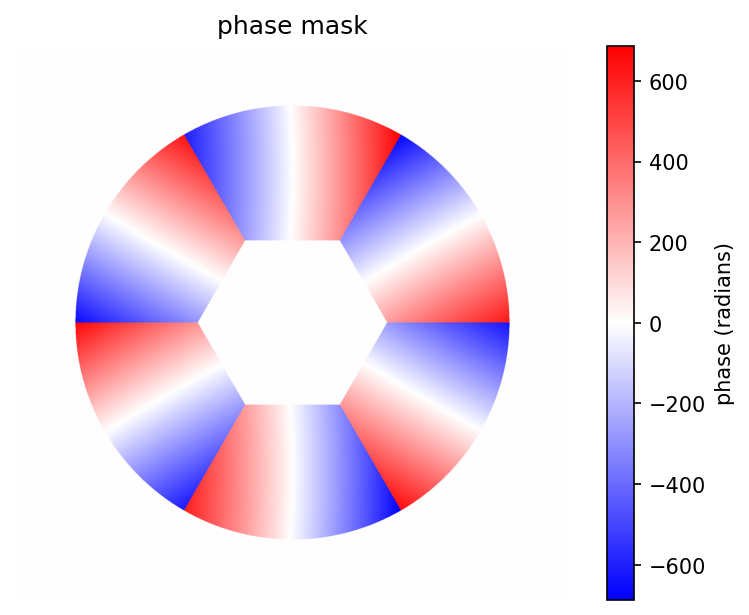

In [4]:
phase = defocused_ramps(
    shape, spacing, spectrum, n, f_objective, NA, delta=[1296.0] * 6
)
plt.figure(dpi=150)
plt.imshow(phase, cmap="bwr")
plt.colorbar(label="phase (radians)")
plt.title("phase mask")
plt.axis("off")
plt.show()

What we want to do is to sandwich this phase mask between two lenses, and then simulate what happens to a point source that we place before the objective lens. We want to be able to move this point source by some `z` value to observe the effect of defocusing the point source away from the focal plane of the objective. In Chromatix, we can describe a point source passing through a thin lens analytically using `objective_point_source`, which produces the field of a potentially defocused point source through the objective lens at the back focal plane of the objective. When we call this element, we must pass the `z` value defining the defocus distance of the point source from the focal plane of the objective. We can then use `phase_change` to apply the phase that we just created at the Fourier plane, and then finally an `ff_lens` (simulating the tube lens), which computes the `Field` at the image plane. We'll put all of this together into our own function `system_psf` which accepts a phase mask and the z values we want to simulate:

In [5]:
# This is where Chromatix is doing its job --- simulating the
# 4f system with a point source at different depths. This lets
# us write the optical simulation part of this model in just
# a few lines of code.
def system_psf(phase: Array, z: Array) -> Field:
    field = objective_point_source(shape, spacing, spectrum, z, f_objective, n, NA)
    field = phase_change(field, phase)
    field = ff_lens(field, f_tube, n)
    return field


psf = system_psf(phase, z)

In [6]:
psf.shape

(40, 1920, 1920)

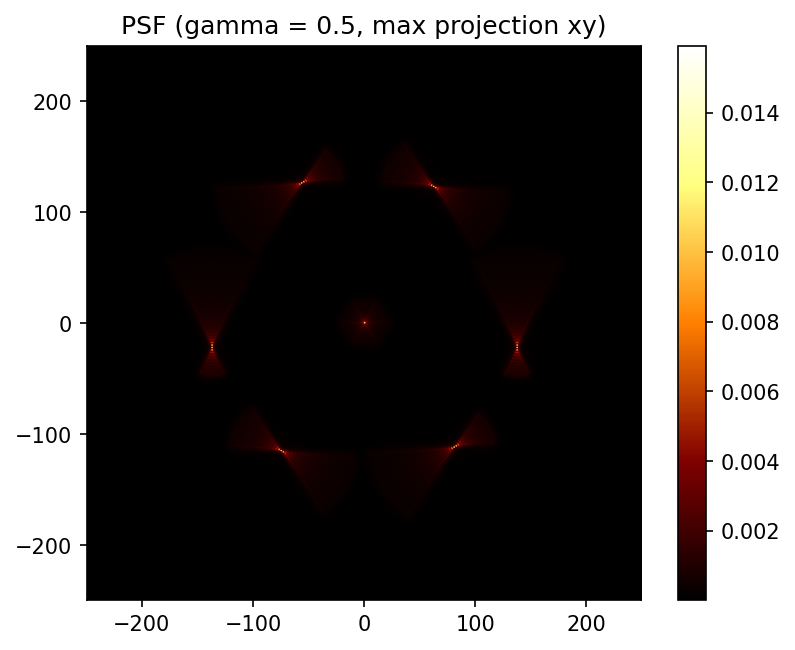

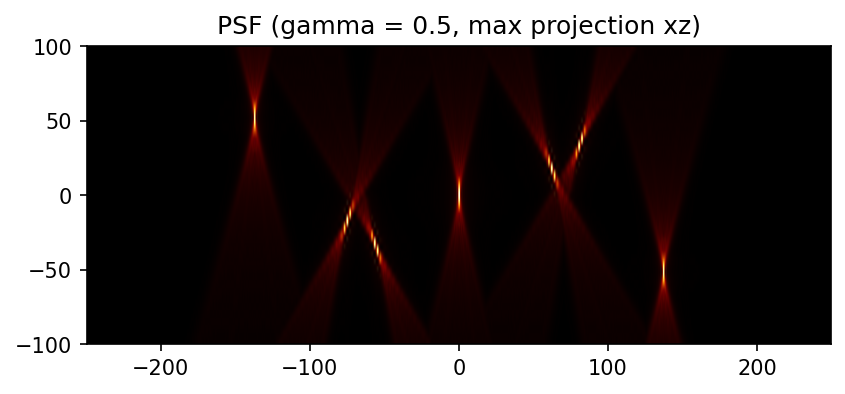

In [7]:
plt.figure(dpi=150)
plt.imshow(
    (psf.intensity**0.5).max(0).squeeze(),
    interpolation="lanczos",
    cmap="afmhot",
    extent=(-249.6, 249.6, -249.6, 249.6),
)
plt.colorbar()
plt.title("PSF (gamma = 0.5, max projection xy)")
plt.show()

plt.figure(dpi=150)
plt.imshow(
    (psf.intensity**0.5).max(1).squeeze(),
    interpolation="lanczos",
    cmap="afmhot",
    extent=(-249.6, 249.6, -100, 100),
)
plt.title("PSF (gamma = 0.5, max projection xz)")
plt.show()

We're simulating the PSF at a very high resolution, but in practice we might want to save memory during the imaging or match the shape of the desired sample or sensor by downsampling the PSF. We could do interpolation for downsampling the PSF to arbitrary shapes, but for now we can follow [[1]](https://openreview.net/forum?id=Kx1VCs1treH) and use a sum pool to downsample the PSF intensity. We'll also taper the PSF to 0 at the edges to avoid artifacts from the cropping.

In [8]:
def crop_and_downsample(psf: Array) -> Array:
    psf = center_crop(psf, (None, pad // 2, pad // 2, None, None))
    psf = psf * sigmoid_taper((1280, 1280), taper_width)
    psf = reduce(
        psf,
        "d (h hf) (w wf) -> d h w",
        reduction="sum",
        hf=downsample_factor,
        wf=downsample_factor,
    )
    return psf

In [9]:
cropped_downsampled_psf = crop_and_downsample(psf.intensity)

In [10]:
cropped_downsampled_psf.shape

(40, 256, 256)

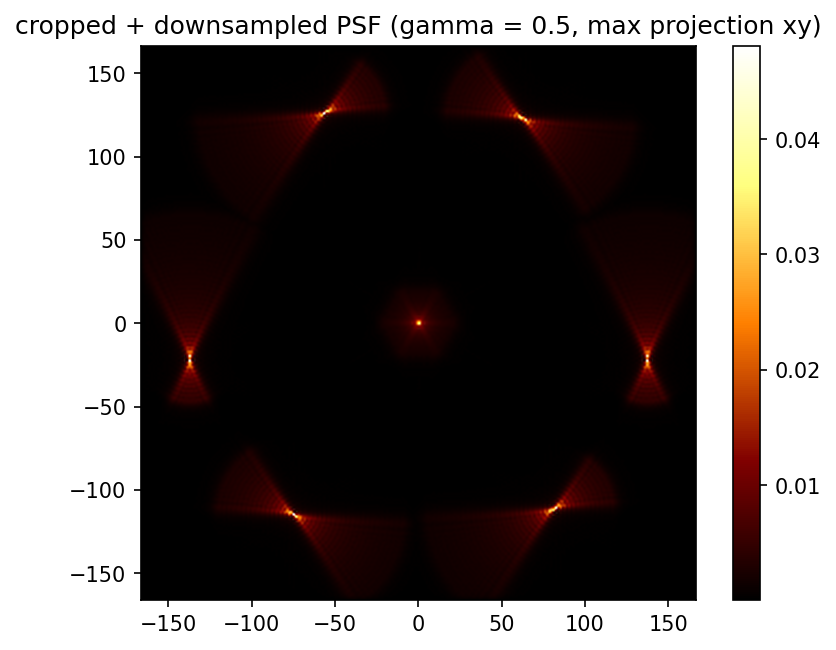

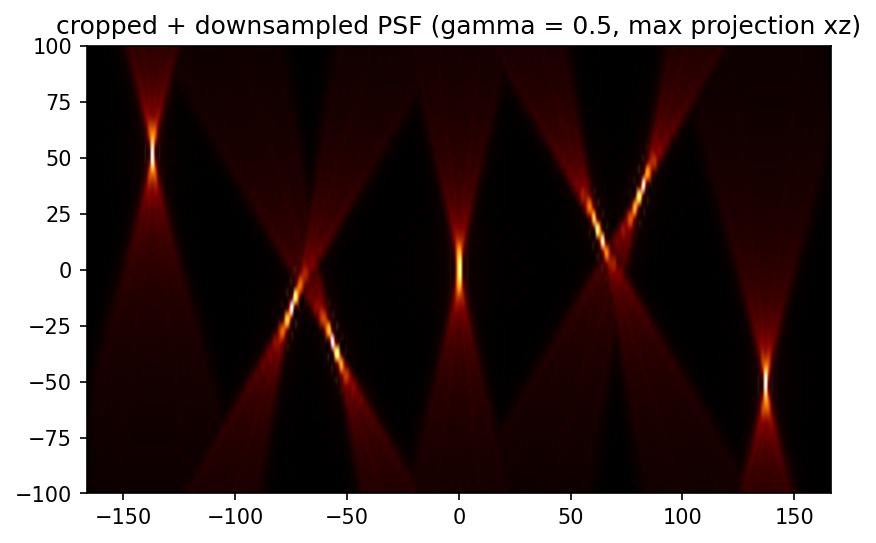

In [11]:
plt.figure(dpi=150)
plt.imshow(
    (cropped_downsampled_psf**0.5).max(0).squeeze(),
    interpolation="lanczos",
    cmap="afmhot",
    extent=(-166.4, 166.4, -166.4, 166.4),
)
plt.colorbar()
plt.title("cropped + downsampled PSF (gamma = 0.5, max projection xy)")
plt.show()

plt.figure(dpi=150)
plt.imshow(
    (cropped_downsampled_psf**0.5).max(1).squeeze(),
    interpolation="lanczos",
    cmap="afmhot",
    extent=(-166.4, 166.4, -100, 100),
)
plt.title("cropped + downsampled PSF (gamma = 0.5, max projection xz)")
plt.show()

## Simulating a snapshot image

We'll be using a synthetic 3D sample of filaments randomly generated using a data generation utility function in Chromatix (because it's easy to load). This is not a particularly realistic or interesting sample, but it should easily highlight how the PSF we generated above captures 3D information of this sample in a 2D image.

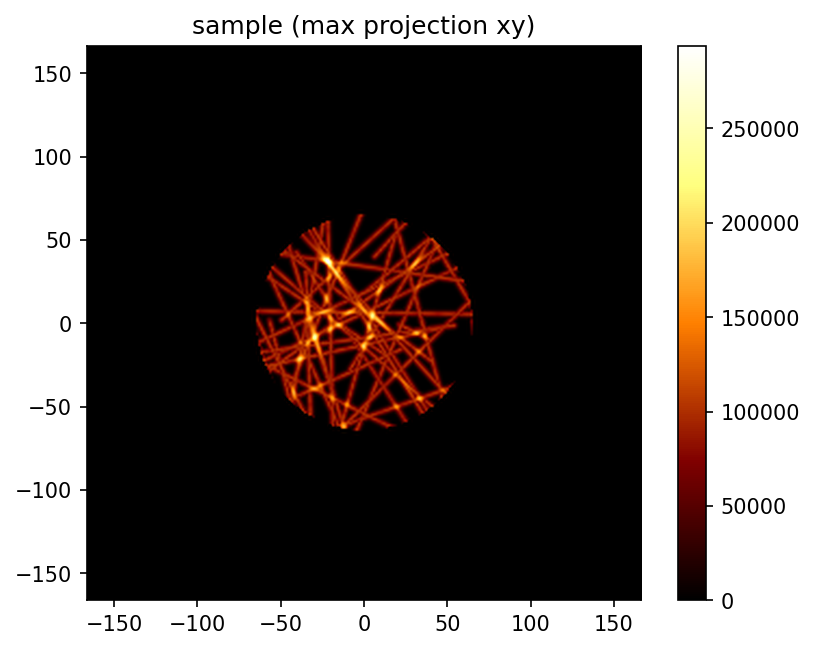

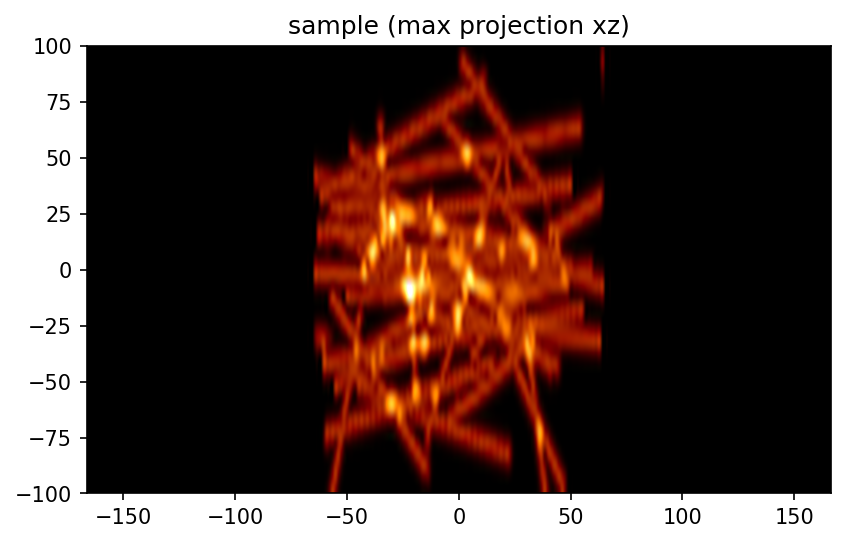

In [12]:
sample = filaments_3d(
    (40, 256, 256), rand_offset=0.5, thickness=1.0, seed=972920147
).astype(np.float32)
# Apply an aperture to the data so the resulting views don't overlap
grid = np.meshgrid(np.linspace(-128, 128, num=256), np.linspace(-128, 128, num=256))
grid = np.sqrt(grid[0] ** 2 + grid[1] ** 2)
sample *= 1e5
sample *= (grid < 50)[None, ...]
plt.figure(dpi=150)
plt.imshow(
    (sample).max(0).squeeze(),
    interpolation="lanczos",
    cmap="afmhot",
    extent=(-166.4, 166.4, -166.4, 166.4),
)
plt.colorbar()
plt.title("sample (max projection xy)")
plt.show()

plt.figure(dpi=150)
plt.imshow(
    (sample).max(1).squeeze(),
    interpolation="lanczos",
    cmap="afmhot",
    extent=(-166.4, 166.4, -100, 100),
)
plt.title("sample (max projection xz)")
plt.show()

In [13]:
@jax.jit
def simulate_image(
    phase: Array,
    z: Array,
    sample: Array,
    key: PRNGKeyArray,
) -> Array:
    psf = system_psf(phase, z).intensity
    psf = crop_and_downsample(psf)
    image = fourier_convolution(psf, sample, axes=(1, 2))
    image = jnp.sum(
        image, axis=0
    )  # Light from all planes of the sample reaches our camera and gets summed
    image = shot_noise(key, image)  # Our camera has shot noise that we can simulate
    return image

Of course, if we wanted to save some computation, we could cache the PSF after we computed it. However, this would not be appropriate if we intended to optimize the phase mask because then we would need to compute the PSF on every iteration of optimzation anyway. Here, we'll proceed without doing any caching, but keep in mind that this will be slower for simulating images of different samples if you do not need to change the phase mask!

For now, with all of the pieces in place, we can finally simulate what an image from the Holoscope looks like!

In [14]:
key = jax.random.PRNGKey(
    4
)  # This PRNG key is used to generate random numbers for simulating shot noise
image = simulate_image(phase, z, sample, key)

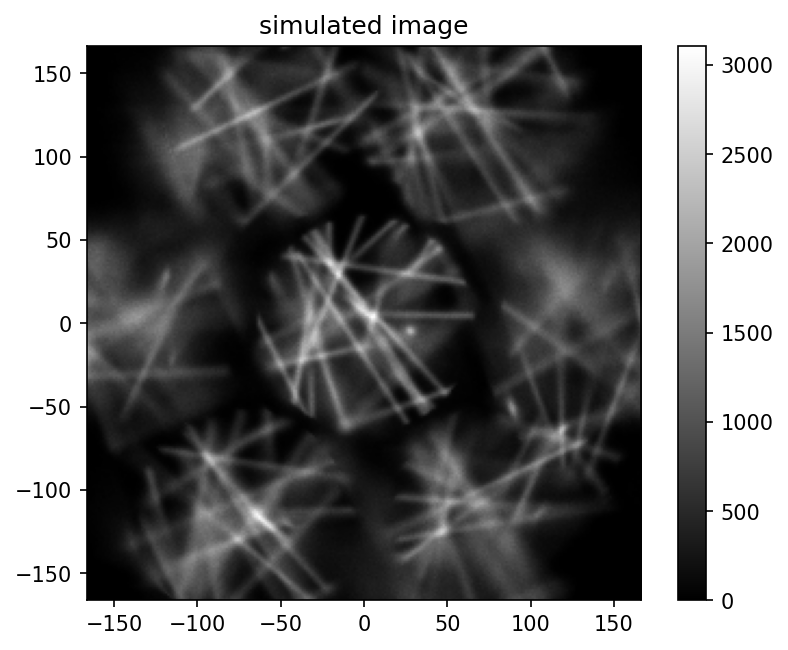

In [15]:
plt.figure(dpi=150)
plt.imshow(image, cmap="gray", extent=(-166.4, 166.4, -166.4, 166.4))
plt.colorbar()
plt.title("simulated image")
plt.show()

We can see that this image consists of multiple views of the sample along different angles, and also with different depth planes in focus in the different views. We could combine this model with a [FourierNet](https://github.com/TuragaLab/fouriernet) to learn to optimize a PSF that is more optimal for this class of sample, but we'll leave that as an exercise for the reader!

## Wrapping up our simulation into a convenient "microscope"


Here we'll show how to define a `Module` for our microscope that holds the optical parameters we need, automatically figures out our spacing, performs the cropping and downsampling we need, simulates the PSF, and finally simulates an image --- basically combining everything we've built so far! These `Module`s are useful when you want to string them together with many neural network layers, serialize (save) the configuration of an involved simulaution, or in general keep track of state that you otherwise would have to pass around separately. A lot of times, you will find that it is more convenient to experiment with the functional style, so this example is here only to show how you might consider structuring your own simulations. Finally, we'll show how this style of microscope simulation is *already* wrapped conveniently as a built-in system in Chromatix.

In [16]:
class Holoscope(eqx.Module):
    camera_shape: tuple[int, int] = eqx.field(
        static=True
    )  # This marks that these attributes should not be differentiable
    camera_pixel_pitch: float = eqx.field(static=True)
    f_objective: float = eqx.field(static=True)
    f_tube: float = eqx.field(static=True)
    n: float = eqx.field(static=True)
    NA: float = eqx.field(static=True)
    spectrum: float = eqx.field(static=True)
    phase: Array  # This is a parameter we want to compute gradients for!
    pad: int = eqx.field(static=True)
    downsample_factor: int = eqx.field(static=True)
    taper_width: float = eqx.field(static=True)

    def __call__(self, sample: Array, z: Array, key: PRNGKeyArray) -> Array:
        psf = self.psf(z).intensity
        psf = self.crop_and_downsample(psf)
        image = fourier_convolution(psf, sample, axes=(1, 2))
        image = jnp.sum(image, axis=0)
        image = shot_noise(key, image)
        return image

    def psf(self, z: Array) -> Field:
        shape = tuple(np.array(self.camera_shape).astype(int) + pad)
        spacing = (
            self.f_tube * self.spectrum / (self.n * shape[0] * self.camera_pixel_pitch)
        )
        field = objective_point_source(
            shape, spacing, self.spectrum, z, self.f_objective, self.n, self.NA
        )
        field = phase_change(field, phase)
        field = ff_lens(field, f_tube, n)
        return field

    def crop_and_downsample(self, psf: Array) -> Array:
        assert self.downsample_factor >= 1, (
            "PSF simulation must have finer spacing than sensor"
        )
        psf = center_crop(psf, (None, pad // 2, pad // 2, None, None))
        psf = psf * sigmoid_taper((1280, 1280), taper_width)
        psf = reduce(
            psf,
            "d (h hf) (w wf) -> d h w",
            reduction="sum",
            hf=downsample_factor,
            wf=downsample_factor,
        )
        return psf

We can use this new `Module` in a similar way to what we did previously, except this is now a composable unit inside or along with any other `Module` s (e.g. in an autoencoder for optimizing PSFs as in [[1]](https://openreview.net/forum?id=Kx1VCs1treH)) and we can compute gradients with respect to the phase mask.

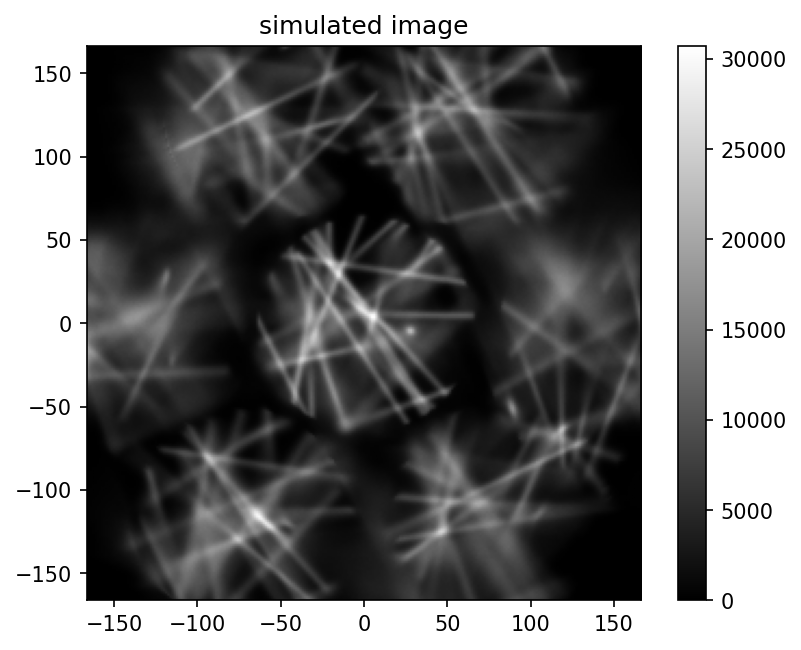

In [17]:
holoscope = Holoscope(
    camera_shape=(1280, 1280),
    camera_pixel_pitch=6.5,
    f_objective=8e3,
    f_tube=200e3,
    n=1.33,
    NA=0.8,
    spectrum=0.532,
    phase=phase,
    pad=640,
    downsample_factor=5,
    taper_width=5.0,
)
image = holoscope(
    sample * 10.0, z, key
)  # Notice how this image is less noisy because we use a brighter sample!
plt.figure(dpi=150)
plt.imshow(image, cmap="gray", extent=(-166.4, 166.4, -166.4, 166.4))
plt.colorbar()
plt.title("simulated image")
plt.show()

In fact, since spatially invariant microscope models are so common in computational imaging, Chromatix already contains a wrapper for this kind of imaging. Further, since the PSF of a 4f system is also a common need, Chromatix also contains a wrapper for this PSF, with an optimizable phase mask (if desired). This `Microscope` `Module` in Chromatix accepts arbitrary models for its PSF, and you can take a look at how to make a `Module` that plugs into this `Microscope` by looking at the [documentation](https://chromatix.readthedocs.io/en/latest/). The `Microscope` also takes a sensor `Module` that can handle resampling of the PSF to shapes that are not integer multiples of the PSF shape, as well as simulate noise. These can be exchanged to simulate different kinds of sensors. The `Microscope` also takes care of padding, cropping, downsampling, and tapering of the PSF automatically, if desired. Here's what the Holoscope could look like in Chromatix:

In [18]:
# This time we will simulate a different phase mask!
new_phase = defocused_ramps(
    shape,
    spacing,
    spectrum,
    n,
    f_objective,
    NA,
    num_ramps=3,
    delta=[1296.0] * 3,
    defocus=[-50.0, 150.0, -100.0],
)
# Now we will create a new Holoscope simulation using what is built-in to Chromatix
holoscope = Microscope(
    system_psf=Optical4FSystemPSF(
        shape=(1280, 1280),
        spacing=6.5,
        f_tube=200e3,
        phase=new_phase,
    ),
    sensor=BasicSensor(
        shape=(
            256,
            256,
        ),  # We choose the number of camera pixels for the cropped FOV we want
        spacing=32.5,  # We set the camera pixel pitch to be large here to enable downsampling
        shot_noise_mode="poisson",  # We want to simulate Poisson shot noise
        resampling_method="cubic",  # You can simulate the PSF at arbitrary pixel sizes relative to the camera pixels
        reduce_axis=0,  # Sums all planes at the camera; if None, simulates the partial image for each plane
    ),
    f=8e3,
    n=1.33,
    NA=0.8,
    spectrum=0.532,
    padding_ratio=0.5,  # Padding takes a proportion instead of a number of pixels
    taper_width=5.0,
)

Let's see a different PSF design using this microscope:

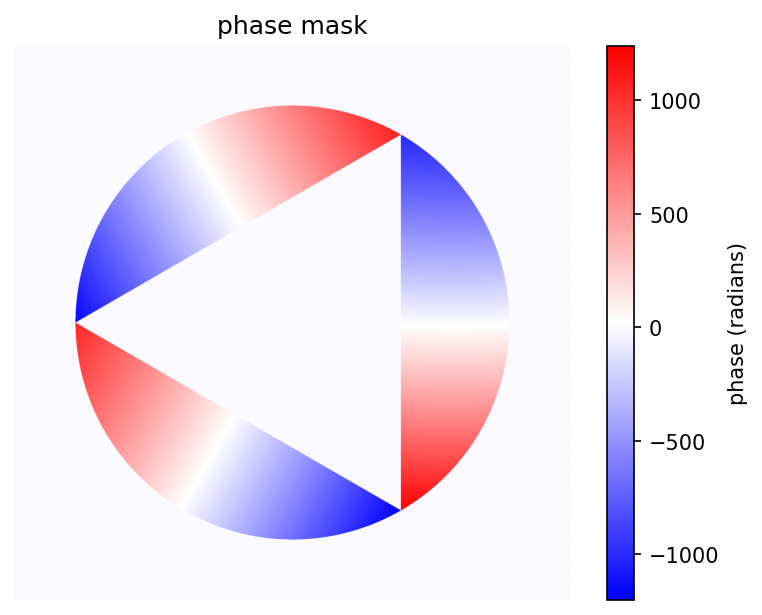

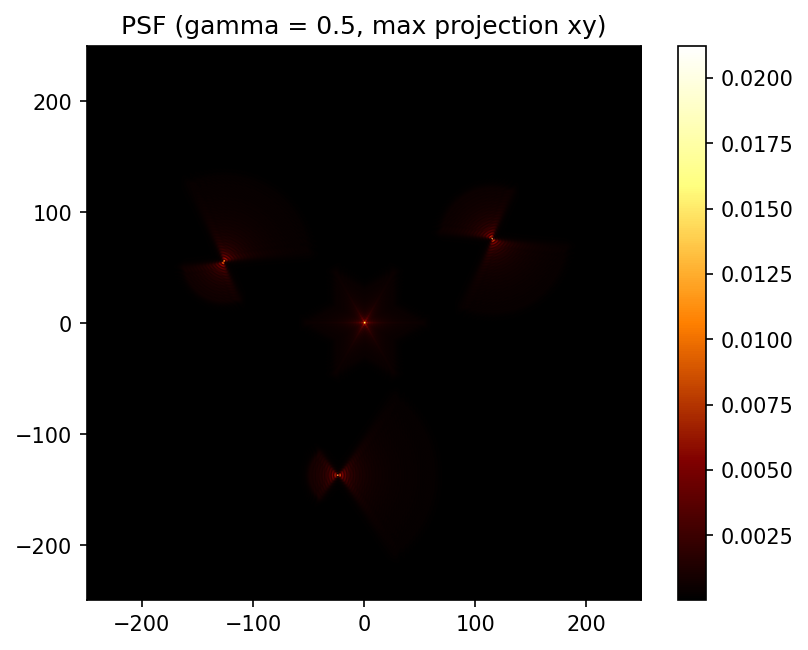

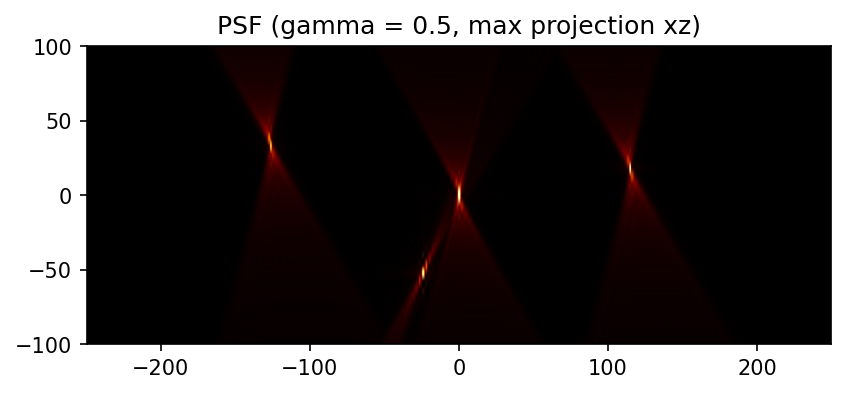

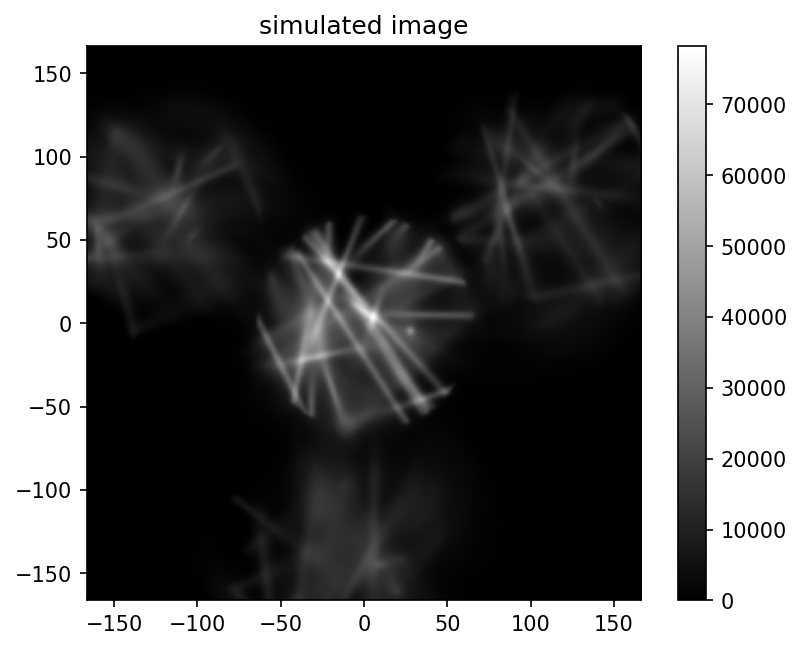

In [19]:
# Visualizing the new phase mask
plt.figure(dpi=150)
plt.imshow(new_phase, cmap="bwr")
plt.colorbar(label="phase (radians)")
plt.title("phase mask")
plt.axis("off")
plt.show()
# Visualizing the simulated PSF
psf = holoscope.psf(z).intensity
plt.figure(dpi=150)
plt.imshow(
    (psf**0.5).max(0).squeeze(),
    interpolation="lanczos",
    cmap="afmhot",
    extent=(-249.6, 249.6, -249.6, 249.6),
)
plt.colorbar()
plt.title("PSF (gamma = 0.5, max projection xy)")
plt.show()

plt.figure(dpi=150)
plt.imshow(
    (psf**0.5).max(1).squeeze(),
    interpolation="lanczos",
    cmap="afmhot",
    extent=(-249.6, 249.6, -100, 100),
)
plt.title("PSF (gamma = 0.5, max projection xz)")
plt.show()
# Visualizing the simulated camera image
new_image = holoscope(sample * 10.0, z, key=key)
plt.figure(dpi=150)
plt.imshow(new_image, cmap="gray", extent=(-166.4, 166.4, -166.4, 166.4))
plt.colorbar()
plt.title("simulated image")
plt.show()